In [1]:
import numpy as np
import torch
import sympy
import torch.nn.functional as F
from utils import *
import pickle
import configparser
import yaml
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [2]:
## keep a num_channel_recoverable (for tacking LHFLX,SHFLX variables)
class ClimateData(DataModel):
    def __init__(self,data_name,Nx,Nt,dt,dx,batch_size,channel_names,\
                 non_eqn_depen_channel, non_eqn_channel, data_file,scaling=1,total_points=-1):
        '''
            currently only batch size of 1 is supported
            Nx is the interpolated dimension 
            Nt max can be 240 (this will take the middle 240 from 7 days i.e skip the 1st day and the last day)
            dt is fixed which is 1800 #can't change 
            dx (the lev tilde will be interpolated from 0 to Nx*dx)(should be 1000/Nx)
            scaling (the scaling value by which the lev coordinates will be scaled, dx,Lx will be scaled)
            batch_size: as of now max is 48 (1 year data)
            data_dir: location of the xarray data
            channel_names: list of channels (variables) ['TAP','QAP']
            channel_const_dict: constant multiplier dict {'TAP':C_P, 'QAP':L_V}
            non_eqn_channel: list of channels(variables) without recoverable eqn ['LHFLX','SHFLX'] (time x batch)
                basically not dependent on lev
        '''
        
        self.scaling = scaling
        dx = scaling*dx
        super(ClimateData,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx)
        self.batch_size = batch_size
        self.ds = xr.open_dataset(data_file)
        self.channel_names = channel_names
        self.non_eqn_depen_channel = non_eqn_depen_channel
        self.n_non_eqn_depen = len(non_eqn_depen_channel)
        self.diff_dict = {"TAP":"DTV","QAP":"VD01","TBP":"TPHYSTND","QBP":"PHQ","TCRM":"TCDTAdiab","QCRM":"QCDTAdiab"}
        self.non_eqn_channel = non_eqn_channel
        self.n_eqn = len(channel_names)
        self.n_non_eqn = len(non_eqn_channel)
        if total_points==-1 or total_points > self.ds.batch_size.size :
            total = self.ds.batch_size.size
        else:
            total = total_points
        
        self.n_batch = total//batch_size
        self.curr_batch = 0
        self.sub, self.div = self._getGlobalStats()
        
        ##future dict is the 
        self.batch_start = 0
        self.batch_end = batch_size
        self._data,self._U_noneqn_dep,self._U_noneqn,self.dict_ = self._generateData()
    
    def _getGlobalStats(self):
        return self.ds.min(),self.ds.max()-self.ds.min()

    def _generateData(self):
        start = (336-self.Nt)//2
        end = start+self.Nt
        
        lev = self.scaling*self.ds.lev.values
        
        U = []
        eqn_channels_vars = []
        non_eqn_depen_channel_vars = []
        non_eqn_channels_vars = []
        diff_dict_key_name = list(self.diff_dict.values())
        diff_values_vars = []
        diff_dict_keys = list(self.diff_dict.keys())

        #shape the eqn vars
        for var in self.channel_names:
            v = self.ds[var][start:end,self.batch_start:self.batch_end].values[:,:,np.newaxis,:]
            v = (v-float(self.sub[var]))/float(self.div[var])
            eqn_channels_vars.append(v)
            
        for var in self.non_eqn_depen_channel:
            v = self.ds[var][start:end,self.batch_start:self.batch_end].values[:,:,np.newaxis,:]
            v = (v-float(self.sub[var]))/float(self.div[var])
            non_eqn_depen_channel_vars.append(v)
        
        for i,var in enumerate(diff_dict_key_name):
            v = self.ds[var][start:end,self.batch_start:self.batch_end].values[:,:,np.newaxis,:]
            if float(self.div[var]) !=0:
                v = (v-float(self.sub[var]))/float(self.div[var])
            diff_values_vars.append(v)
            
        n_diff_values_vars = len(diff_values_vars)
        #shape the non eqn vas
        for var in self.non_eqn_channel:
            v = self.ds[var][start:end,self.batch_start:self.batch_end].values[:,:,np.newaxis]
            v = np.tile(v,[1,1,self.Nx])
            v = v[:,:,np.newaxis,:]
            v = (v-float(self.sub[var]))/float(self.div[var])
            non_eqn_channels_vars.append(v)
        
        # interpolate the eqn variables
        self.lev_tilde_after =  np.linspace(0,self.Lx,num=self.Nx)

        eqn_channels_vars_interp = []
        non_eqn_depen_channel_vars_interp = []
        diff_values_vars_interp = []

        for i,v in enumerate(eqn_channels_vars+diff_values_vars+non_eqn_depen_channel_vars):
            batch_size = v.shape[1]
            v_interp = np.zeros(v.shape[:-1]+(self.Nx,))
            
            for t in range(self.Nt):
                for b in range(batch_size):
                    interp = np.interp(self.lev_tilde_after,lev,v[t][b][0])
                    v_interp[t][b][0] = interp
        
            if i<self.n_eqn:
                eqn_channels_vars_interp.append(v_interp) 
                
            elif i<self.n_eqn+n_diff_values_vars:
                diff_values_vars_interp.append(v_interp)
            else:
                non_eqn_depen_channel_vars_interp.append(v_interp)
                
                
        
        U = np.concatenate(eqn_channels_vars_interp,axis=2)
        dict_ = {"AP":[],"BP":[],"CRM":[]}
        dict_keys = list(dict_.keys())
        for i in range(3):
            dict_[dict_keys[i]] = torch.from_numpy(np.concatenate(diff_values_vars_interp[2*i:2*i+2],axis=2)).type(torch.DoubleTensor)

        _U_noneqn = np.concatenate(non_eqn_channels_vars,axis=2)
        _U_noneqn_dep = np.concatenate(non_eqn_depen_channel_vars_interp,axis=2)
        return U,_U_noneqn_dep,_U_noneqn,dict_
        

    def data(self,step_num):
        '''
            fetches the next batch
        '''

#         self.batch_start = self.curr_batch*self.batch_size
#         self.batch_end = self.batch_start + self.batch_size
#         self.curr_batch += 1
#         self._data,self._U_noneqn,self.dict_ = self._generateData()
#         if self.curr_batch >= self.n_batch:
#             self.curr_batch = 0
        return torch.from_numpy(self._data[:step_num]),torch.from_numpy(self._U_noneqn_dep[:step_num]),\
                torch.from_numpy(self._U_noneqn[:step_num]).type(torch.DoubleTensor),\
                self.dict_
                    
    
        
    def visualize(self,b,subset=True):
        #displays ith batch plot
        ##time x batch_size x 1 x x_dim 
        u = []
        v = []
        x,t = self._getMeshPoints()
        disp_arr = self._data
            
        for i in range(len(self._data)):
            u.append(np.array(disp_arr[i][b][0]).reshape(-1))
            v.append(np.array(disp_arr[i][b][1]).reshape(-1))
            
        u = np.array(u)
        v = np.array(v)
        
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,t)        
        surf = ax.plot_surface(T, X, u)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.title(self.channel_names[0])
        plt.show()
        
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,t)        
        surf = ax.plot_surface(T, X, v)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.title(self.channel_names[1])
        plt.show()
        
        


In [3]:
class SymNet(torch.nn.Module):
    def __init__(self, n_hidden, n_deriv_channel, deriv_channel_names=None, normalization_weight=None):
        '''
        Input:
            n_channel = Number of derivatives using (u,ux,vx,vxx)
        '''
        super(SymNet, self).__init__()
        self.n_hidden = n_hidden
        self.n_deriv_channel = n_deriv_channel
        if deriv_channel_names is None:
            deriv_channel_names = list('u_'+str(i) for i in range(self.n_deriv_channel))
        self.deriv_channel_names = deriv_channel_names
        layers = []
        for k in range(n_hidden):
            module = torch.nn.Linear(n_deriv_channel+k,2)
            self.add_module('layer'+str(k), module)
            layers.append(self.__getattr__('layer'+str(k)))
        module = torch.nn.Linear(n_deriv_channel+n_hidden, 1)
        self.add_module('layer_final', module)
        layers.append(self.__getattr__('layer_final'))
        self.layers = tuple(layers)
        
        
    def forward(self, inputs):
        '''
            inputs tensor be of shape (batch_size x X_dim x n_derivatives)
            output shape batch_size x X_dim
        '''
        outputs = inputs.type(torch.FloatTensor)
        for k in range(self.n_hidden):
            
            o = self.layers[k](outputs)
            outputs = torch.cat([outputs,o[...,:1]*o[...,1:]], dim=-1)
        outputs = self.layers[-1](outputs)
        return outputs[...,0]
    
    
    
    def _cast2symbol(self,layer):
        weight,bias = layer.weight.data.cpu().numpy(), \
                    layer.bias.data.cpu().numpy()
        weight,bias = sympy.Matrix(weight),sympy.Matrix(bias)
        return weight,bias

    def _sympychop(self,o, calprec):
        for i in range(o.shape[0]):
            cdict = o[i].expand().as_coefficients_dict()  
            o_i = 0
            for k,v in cdict.items():
                if abs(v)>0.1**calprec:
                    o_i = o_i+k*v
            o[i] = o_i
        return o

    def getEquation(self,calprec=6):
        ## assume symnet model

        deriv_channels = sympy.symbols(self.deriv_channel_names)
        deriv_channels = sympy.Matrix([deriv_channels,])
        for i in range(self.n_hidden):
            weight,bias = self._cast2symbol(self.layers[i])
            o = weight*deriv_channels.transpose()+bias
            o = self._sympychop(o, calprec) #ignores very low params terms
            deriv_channels = list(deriv_channels)+[o[0]*o[1],]
            deriv_channels = sympy.Matrix([deriv_channels,])

        weight,bias = self._cast2symbol(self.layers[-1])
        o = (weight*deriv_channels.transpose()+bias)
        o = self._sympychop(o,calprec)

        return o[0]


In [4]:
class FD1D(torch.nn.Module):
    '''
        Finite Differences scheme for 1D dependency
        acc_order list of acc_order for diff_order
        kernel size should be greater than or equal to the max_diff_order (otherwise error will be thrown)
        diff_order starts from 0,1,... 
        constarint: Moment matrix constraint "free" or "moment"
        Basically this class initializes one kernel of the specified parameters
    '''
    def __init__(self,dx, kernel_size, diff_order,acc_order,constraint='free'):
        super(FD1D, self).__init__()
        self.dx = dx
        self.kernel_size = kernel_size
        self.diff_order = diff_order
        self.acc_order = acc_order
        self.constraint = constraint
        ## will only be used in case of contraint = 'free'
        if constraint=='free':
            self._kernel = (getKernelTorch(diff_order,acc_order+1,dim=kernel_size,scheme='central')/(dx**diff_order)).type(torch.DoubleTensor)
            
        ##Moment to kernel and vice versa
        if constraint=='moment':
            self.m2k = M2K(kernel_size)
            self.k2m = K2M(kernel_size)
            #define moment matrix
            moment = torch.DoubleTensor(kernel_size).zero_()
            moment[diff_order] = 1
            moment = moment.reshape(1,1,-1)
            self.moment = torch.nn.Parameter(moment) ## now weights will be updated on this
            ##create a mask for gradeint hook
            self.gradient_mask = self._getGradientMask()
            ##register hook to the moment matrix
            self.moment.register_hook(lambda grad: grad.mul_(self.gradient_mask))
        
        
    @property
    def kernel(self):
        if self.constraint == 'moment':
            kernel = self.m2k(self.moment)/(self.dx**self.diff_order)
        else:
            kernel = self._kernel
            
            
        return kernel
    
    def _getGradientMask(self):
        gradient_mask = torch.ones(self.kernel_size,dtype=torch.double)
        order_bank = np.arange(self.kernel_size)
        for j in range(self.diff_order+self.acc_order):
            gradient_mask[order_bank[j]] = 0
        gradient_mask = gradient_mask.reshape(1,1,-1)
        return gradient_mask
        
    def forward(self,inputs):
        '''
            Process:
            Need to pad the input and then appy conv1D
            input shape can be batch_size x n_channels x x_dim
        '''
        inp_padded = padInputTorch(inputs,self.diff_order,self.acc_order+1,dim=self.kernel_size) #batch_size x n_channels x (x_dim+padded)
#         print(inp_padded)
        conv = F.conv1d(inp_padded.type(torch.DoubleTensor),self.kernel)
        return conv
        

In [5]:
'''
Modifying to incorporate untrainable/unlearnable equation channel with and without the lev derivative
'''

class PdeNet(torch.nn.Module):
    def __init__(self,dt, dx, kernel_size, max_diff_order, n_channel,channel_names,
                 n_non_eqn_channels,non_eqn_channel_names,dependent_channels,
                 acc_order=2,n_hidden=2,\
                constraint='free'):
        '''
        Input:
        '''
        super(PdeNet, self).__init__()
        self.dx = dx
        self.dt = dt
        self.kernel_size = kernel_size
        self.max_diff_order = max_diff_order
        self.n_channel = n_channel
        self.channel_names = channel_names
        self.n_non_eqn_channels = n_non_eqn_channels
        self.non_eqn_channel_names = non_eqn_channel_names
        self.dependent_channels = dependent_channels
        self.n_dependent_channels = len(dependent_channels)
        self.n_hidden = n_hidden
        self.constraint = constraint
                        
        if not np.iterable(acc_order):
            acc_order = [acc_order,]*(self.max_diff_order+1)
            
        self.acc_order = acc_order
        
        #conv operation
        for i in range(max_diff_order+1):
            kernel = FD1D(dx,kernel_size,i,acc_order[i],constraint=constraint)
            self.add_module('fd'+str(i), kernel) #finite difference of order
            
        #symnet 
        c = channel_names.split(',')
        derivative_channels = []
        for ch in c+self.dependent_channels:
            for k in range(max_diff_order+1):
                derivative_channels.append(ch+'_'+str(k))
                
        '''CHANGED: for climate''' 
        for ch in non_eqn_channel_names:
            derivative_channels.append(ch)
        
            
        self.derivative_channels = derivative_channels 
        all_symnets = []
        for k in range(self.n_channel):
            self.add_module("symnet_"+str(k),SymNet(n_hidden,len(derivative_channels), deriv_channel_names=derivative_channels))
            all_symnets.append(self.__getattr__('symnet_'+str(k)))
        self.all_symnets = all_symnets
    
    @property
    def fds(self):
        for i in range(self.max_diff_order+1):
            yield self.__getattr__('fd'+str(i))
                
    def multistep(self,inputs,non_eqn_depe,non_eqn_t,diff_values,step_num):
        #pass it throught the kernels then the symmnet to 
        '''
        Takes multistep through the whole PDE Net.
        '''
        u = inputs
        for i in range(step_num):
            uadd = self.RightHandItems(u,non_eqn_depe,non_eqn_t)#will take a dt step from u using the network 
            u = u + self.dt*(uadd+diff_values[0]+diff_values[1]) #only for QBP
        return u
    
    def symNetParams(self):
        params = []
        for symnet in self.all_symnets:
            params += list(symnet.parameters())
        return params
    
    def diffParams(self):
        params = []
        for fd in self.fds:
            params += list(fd.parameters())
        return params

    def RightHandItems(self,u,non_eqn_depe,non_eqn_t):
        
        #convolve the u with the derivative kernals to get the different derivatives 
        #batch_size x n_channels x X_dim
        derives = []
        u_split = u.split(1,dim=1)
        non_eqn_depe_split = non_eqn_depe.split(1,dim=1)
        for ch in range(self.n_channel):       
            for i in range(self.max_diff_order+1):
                fd_obj = self.__getattr__('fd'+str(i))
                deriv_channel_ch_order_i = fd_obj(u_split[ch])
                derives.append(deriv_channel_ch_order_i)   
        
        for ch in range(self.n_dependent_channels):
            for i in range(self.max_diff_order+1):
                fd_obj = self.__getattr__('fd'+str(i))
                deriv_channel_ch_order_i = fd_obj(non_eqn_depe_split[ch])
                derives.append(deriv_channel_ch_order_i)   
                
                
            
        U = torch.cat(derives, dim=1) #batch_size x n_derivatives x X_dim 
        U = torch.cat([U,non_eqn_t],dim=1)
        
        #symnet_output = (batch_size x X_dim x n_derivatives)
        u_outs = []
        for symnet in self.all_symnets:
            u_symnet = symnet(U.permute(0,2,1)) #batch_size x X_dim x n_derivatives
            u_out = u_symnet.unsqueeze_(1)
            u_outs.append(u_out)
        u_out = torch.cat(u_outs,axis=1)#only 1 channel as there will only be 1 symnet
        return u_out
        
        
    def forward(self,inputs,non_eqn_depe,non_eqn_t,diff_values,step_num):
        '''
            inputs of shape batch_size x n_channels x X_dim
            step_nums = number of dt blocks to calculate the inputs for
        '''
        return self.multistep(inputs,non_eqn_depe,non_eqn_t,diff_values,step_num)

    

In [6]:
def symnetRegularizeLoss(model):
    loss = 0
    s = 1e-2
    for p in model.symNetParams():
        p = p.abs()
        loss = loss+((p<s).to(p)*0.5/s*p**2).sum()+((p>=s).to(p)*(p-s/2)).sum()
    return loss

In [7]:
def momentRegularizeLoss(model):
    loss = 0
    s = 1e-2
    for p in model.diffParams():
        p = p.abs()
        loss = loss+((p<s).to(p)*0.5/s*p**2).sum()+((p>=s).to(p)*(p-s/2)).sum()

    return loss

In [8]:
#global names are all the parameters
def modelLoss(model,u_obs,non_eqn_dep_obs,non_eqn_obs,diff_dict,config,block):
    '''
        Returns the loss value for so that it can be given to an optimizer
        Inputs:
            u_obs (batch_size x n_channels x X_dim)
            blocks is stepnum
    '''
    sparsity = config['sparsity']
    momentsparsity = config['momentsparsity']
    
    
    if block==0: #warmup
        sparsity = 0
        momentsparsity = 0
    step_num = block if block>=1 else 1
    dt = config['dt']
    data_loss = 0
    symnet_loss = symnetRegularizeLoss(model)
    moment_loss = momentRegularizeLoss(model)
    ut = u_obs[0]
    loss_mse = 0
    mse_loss = torch.nn.MSELoss()
    for steps in range(1,step_num+1):
        non_eqn_t = non_eqn_obs[steps-1]
        non_eqn_dep_t = non_eqn_dep_obs[steps-1]
        diff_values = [diff_dict['AP'][steps-1][:,-1:,:],diff_dict['CRM'][steps][:,-1:,:]] #for QBP
        ut_next_predicted = model(ut,non_eqn_dep_t,non_eqn_t,diff_values,step_num=1) #take one step from this point #only 1 channel(QBP)
        loss_mse_t = mse_loss(ut_next_predicted,u_obs[steps])
        loss_mse += loss_mse_t
        data_loss += (loss_mse_t/dt**2)/step_num
        ut = ut_next_predicted
        

    loss = data_loss+stepnum*sparsity*symnet_loss+stepnum*momentsparsity*moment_loss
    if torch.isnan(loss):
#         raise "Loss Nan"
        loss = (torch.ones(1,requires_grad=True)/torch.zeros(1)).to(loss)
    return loss,data_loss,symnet_loss,moment_loss,loss_mse


In [9]:
##modify channel names and length
def setenv(config): #return model and datamodel
    model = PdeNet(config['dt'],config['dx']*config['scaling'],config['kernel_size'],config['max_diff_order']\
                   ,config['n_channels'],config['channel_names'],
                   config['n_non_eqn_channels'],config['non_eqn_channels'],
                   config['dependent_channels'],
                   config['acc_order'],config['n_hidden_layers'],config['constraint'])
    
    data_model =  ClimateData(config['dataname'],config['Nx'],config['Nt']
                              ,config['dt'],config['dx'],config['batch_size'],config['channel_vars'],\
                              config['dependent_channels'],
                              config['non_eqn_channels'],config['data_file'],config['scaling'],config["total"])
        
    #possible some callbacks
    callbacks = None
    return model,data_model,callbacks

In [40]:
with open("config_AP_climate.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [41]:
config

{'name': 'Climate BP',
 'dt': 1800,
 'dx': 10,
 'scaling': 30,
 'blocks': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'kernel_size': 5,
 'max_diff_order': 2,
 'acc_order': 2,
 'n_hidden_layers': 2,
 'n_channels': 1,
 'n_non_eqn_channels': 4,
 'dataname': 'Climate BP',
 'batch_size': 48,
 'total': -1,
 'channel_names': 'QBP',
 'channel_vars': ['QBP'],
 'non_eqn_channels': ['LHFLX', 'SHFLX', 'PS', 'SOLIN'],
 'dependent_channels': ['TBP'],
 'data_file': '/Users/ankitesh/Desktop/RA_data/preprocessed_pde_cluster_1.nc',
 'Nt': 240,
 'Nx': 100,
 'sparsity': 0.005,
 'momentsparsity': 0.004,
 'epochs': 1000,
 'model_dir': '/Users/ankitesh/Desktop/RA_data/',
 'seed': -1,
 'learning_rate': 0.002,
 'constraint': 'moment',
 'optimizer': 'Adam'}

In [42]:
blocks = config['blocks']
dt = config['dt']
dx = config['dx']
epochs = config['epochs']
lr = config['learning_rate']
opti = config['optimizer']

In [43]:
model,data_model,callbacks = setenv(config)

In [33]:
def getOptimizer(config):
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    if config['optimizer'] == 'LBFGS':
        optimizer = LBFGSNew(model.parameters(), history_size=7, max_iter=10, line_search_fn=True,batch_mode=True)

    return optimizer

In [45]:
##optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [ ]:
for block in blocks:
    print('[PRINT] block:',block)
    if block==0:
        print('[PRINT] Warmum Stage')
    stepnum = block if block>=1 else 1
    #get the data at this time #shape [block,batch,channel,X_dim]
    u_obs,non_eqn_dep_t,non_eqn_t,diff_dict = data_model.data(stepnum+1) #np array of stepnum elements 
    
    for epoch in range(epochs):
            #zero grad 
            
        
        optimizer.zero_grad()
        #forward
        loss,data_loss,syment_reg,moment_loss,loss_mse = modelLoss(model,u_obs,non_eqn_dep_t,non_eqn_t,diff_dict,config,block)
        loss.backward()

        optimizer.step()

        if epoch%10==0:
            print("[PRINT] Epoch: %d, Loss: %.5f, Mse Loss: %.5f, Data Loss: %.5f, Symnet Regularize: %.5f, Moment Regularize: %.5f "\
                  % (epoch,loss,loss_mse,\
                      data_loss,syment_reg,\
                      moment_loss))
        #save at every 500th epoch
        if epoch%500==0:
            name = "Block_"+str(block)+"_Epoch_"+str(epoch)+".pth"
            torch.save(model.state_dict(),config['model_dir']+name)
            
    my_lr_scheduler.step()
    name = "Block_"+str(block)+"_Epoch_"+str(epochs)+".pth"
    torch.save(model.state_dict(),config['model_dir']+name)
    epochs += 1000

In [ ]:
for block in blocks:
    print('[PRINT] block:',block)
    if block==0:
        print('[PRINT] Warmum Stage')
    stepnum = block if block>=1 else 1
    #get the data at this time #shape [block,batch,channel,X_dim]
    u_obs,non_eqn_dep_t,non_eqn_t,diff_dict = data_model.data(stepnum+1) #np array of stepnum elements 
    
    for epoch in range(epochs):
            #zero grad 
        def closure():
            optimizer.zero_grad()
        #forward
            loss,data_loss,syment_reg,moment_loss,loss_mse = modelLoss(model,u_obs,non_eqn_dep_t,non_eqn_t,diff_dict,config,block)
            if loss.requires_grad:
                    loss.backward()
            return loss
        def closureTemp():
            optimizer.zero_grad()
            loss,data_loss,syment_reg,moment_loss,loss_mse = modelLoss(model,u_obs,non_eqn_dep_t,non_eqn_t,diff_dict,config,block)
            loss.backward()
            return loss,data_loss,syment_reg,moment_loss,loss_mse

        optimizer.step(closure)

        if epoch%10==0:
            loss,data_loss,syment_reg,moment_loss,loss_mse = closureTemp()
            print("[PRINT] Epoch: %d, Loss: %.5f, Mse Loss: %.5f, Data Loss: %.5f, Symnet Regularize: %.5f, Moment Regularize: %.5f "\
                  % (epoch,loss,loss_mse,\
                      data_loss,syment_reg,\
                      moment_loss))
        #save at every 500th epoch
        if epoch%500==0:
            name = "Block_"+str(block)+"_Epoch_"+str(epoch)+".pth"
            torch.save(model.state_dict(),config['model_dir']+name)
            
    my_lr_scheduler.step()
    name = "Block_"+str(block)+"_Epoch_"+str(epochs)+".pth"
    torch.save(model.state_dict(),config['model_dir']+name)
    epochs += 1000

[PRINT] block: 0
[PRINT] Warmum Stage
[PRINT] Epoch: 0, Loss: 0.09941, Mse Loss: 322095.13214, Data Loss: 0.09941, Symnet Regularize: 8.88200, Moment Regularize: 2.98605 
[PRINT] Epoch: 10, Loss: 0.08972, Mse Loss: 290682.67045, Data Loss: 0.08972, Symnet Regularize: 8.82607, Moment Regularize: 3.07445 
[PRINT] Epoch: 20, Loss: 0.08008, Mse Loss: 259471.49140, Data Loss: 0.08008, Symnet Regularize: 8.92239, Moment Regularize: 3.16913 
[PRINT] Epoch: 30, Loss: 0.06990, Mse Loss: 226481.49753, Data Loss: 0.06990, Symnet Regularize: 9.25113, Moment Regularize: 3.23195 
[PRINT] Epoch: 40, Loss: 0.05883, Mse Loss: 190620.61678, Data Loss: 0.05883, Symnet Regularize: 9.68301, Moment Regularize: 3.27326 
[PRINT] Epoch: 50, Loss: 0.04708, Mse Loss: 152535.44464, Data Loss: 0.04708, Symnet Regularize: 10.17115, Moment Regularize: 3.32783 
[PRINT] Epoch: 60, Loss: 0.03554, Mse Loss: 115160.84279, Data Loss: 0.03554, Symnet Regularize: 10.68432, Moment Regularize: 3.35394 
[PRINT] Epoch: 70, Loss

[PRINT] Epoch: 610, Loss: 0.00770, Mse Loss: 24932.38236, Data Loss: 0.00770, Symnet Regularize: 21.60646, Moment Regularize: 6.04008 
[PRINT] Epoch: 620, Loss: 0.00767, Mse Loss: 24839.27487, Data Loss: 0.00767, Symnet Regularize: 21.83300, Moment Regularize: 6.10940 
[PRINT] Epoch: 630, Loss: 0.00764, Mse Loss: 24746.91315, Data Loss: 0.00764, Symnet Regularize: 22.05547, Moment Regularize: 6.17664 
[PRINT] Epoch: 640, Loss: 0.00761, Mse Loss: 24655.23043, Data Loss: 0.00761, Symnet Regularize: 22.27374, Moment Regularize: 6.24173 
[PRINT] Epoch: 650, Loss: 0.00758, Mse Loss: 24564.15797, Data Loss: 0.00758, Symnet Regularize: 22.48776, Moment Regularize: 6.30459 
[PRINT] Epoch: 660, Loss: 0.00755, Mse Loss: 24473.62352, Data Loss: 0.00755, Symnet Regularize: 22.69747, Moment Regularize: 6.36516 
[PRINT] Epoch: 670, Loss: 0.00753, Mse Loss: 24383.56106, Data Loss: 0.00753, Symnet Regularize: 22.90283, Moment Regularize: 6.42338 
[PRINT] Epoch: 680, Loss: 0.00750, Mse Loss: 24293.8872

[PRINT] Epoch: 220, Loss: 0.05970, Mse Loss: 26614.57646, Data Loss: 0.00821, Symnet Regularize: 7.46493, Moment Regularize: 3.54014 
[PRINT] Epoch: 230, Loss: 0.05811, Mse Loss: 26401.93964, Data Loss: 0.00815, Symnet Regularize: 7.18931, Moment Regularize: 3.50399 
[PRINT] Epoch: 240, Loss: 0.05655, Mse Loss: 26438.98263, Data Loss: 0.00816, Symnet Regularize: 6.90356, Moment Regularize: 3.46857 
[PRINT] Epoch: 250, Loss: 0.05516, Mse Loss: 26485.97833, Data Loss: 0.00817, Symnet Regularize: 6.64991, Moment Regularize: 3.43388 
[PRINT] Epoch: 260, Loss: 0.05377, Mse Loss: 26498.55604, Data Loss: 0.00818, Symnet Regularize: 6.39910, Moment Regularize: 3.39974 
[PRINT] Epoch: 270, Loss: 0.05242, Mse Loss: 26523.82607, Data Loss: 0.00819, Symnet Regularize: 6.15459, Moment Regularize: 3.36607 
[PRINT] Epoch: 280, Loss: 0.05109, Mse Loss: 26521.30106, Data Loss: 0.00819, Symnet Regularize: 5.91444, Moment Regularize: 3.33292 
[PRINT] Epoch: 290, Loss: 0.04978, Mse Loss: 26524.43753, Data

[PRINT] Epoch: 840, Loss: 0.03022, Mse Loss: 27607.98540, Data Loss: 0.00852, Symnet Regularize: 1.95107, Moment Regularize: 2.98517 
[PRINT] Epoch: 850, Loss: 0.02993, Mse Loss: 27312.53005, Data Loss: 0.00843, Symnet Regularize: 1.91156, Moment Regularize: 2.98519 
[PRINT] Epoch: 860, Loss: 0.02965, Mse Loss: 27061.03361, Data Loss: 0.00835, Symnet Regularize: 1.87082, Moment Regularize: 2.98521 
[PRINT] Epoch: 870, Loss: 0.02937, Mse Loss: 26820.54403, Data Loss: 0.00828, Symnet Regularize: 1.83030, Moment Regularize: 2.98522 
[PRINT] Epoch: 880, Loss: 0.02910, Mse Loss: 26615.75759, Data Loss: 0.00821, Symnet Regularize: 1.78845, Moment Regularize: 2.98524 
[PRINT] Epoch: 890, Loss: 0.02883, Mse Loss: 26423.92301, Data Loss: 0.00816, Symnet Regularize: 1.74662, Moment Regularize: 2.98525 
[PRINT] Epoch: 900, Loss: 0.02857, Mse Loss: 26250.26659, Data Loss: 0.00810, Symnet Regularize: 1.70443, Moment Regularize: 2.98526 
[PRINT] Epoch: 910, Loss: 0.02830, Mse Loss: 26089.96158, Data

[PRINT] Epoch: 1450, Loss: 0.02663, Mse Loss: 24218.56454, Data Loss: 0.00747, Symnet Regularize: 1.44321, Moment Regularize: 2.98541 
[PRINT] Epoch: 1460, Loss: 0.02663, Mse Loss: 24216.74528, Data Loss: 0.00747, Symnet Regularize: 1.44332, Moment Regularize: 2.98541 
[PRINT] Epoch: 1470, Loss: 0.02663, Mse Loss: 24215.07348, Data Loss: 0.00747, Symnet Regularize: 1.44342, Moment Regularize: 2.98541 
[PRINT] Epoch: 1480, Loss: 0.02663, Mse Loss: 24213.55026, Data Loss: 0.00747, Symnet Regularize: 1.44351, Moment Regularize: 2.98541 
[PRINT] Epoch: 1490, Loss: 0.02663, Mse Loss: 24212.15667, Data Loss: 0.00747, Symnet Regularize: 1.44360, Moment Regularize: 2.98541 
[PRINT] Epoch: 1500, Loss: 0.02663, Mse Loss: 24210.87677, Data Loss: 0.00747, Symnet Regularize: 1.44368, Moment Regularize: 2.98541 
[PRINT] Epoch: 1510, Loss: 0.02663, Mse Loss: 24209.71139, Data Loss: 0.00747, Symnet Regularize: 1.44375, Moment Regularize: 2.98541 
[PRINT] Epoch: 1520, Loss: 0.02663, Mse Loss: 24208.649

[PRINT] Epoch: 60, Loss: 112.48921, Mse Loss: 728582521.17668, Data Loss: 112.43557, Symnet Regularize: 1.80976, Moment Regularize: 4.44185 
[PRINT] Epoch: 70, Loss: 0.24656, Mse Loss: 1245501.63278, Data Loss: 0.19221, Symnet Regularize: 1.79026, Moment Regularize: 4.55663 
[PRINT] Epoch: 80, Loss: 13.23513, Mse Loss: 85408358.17912, Data Loss: 13.18030, Symnet Regularize: 1.81043, Moment Regularize: 4.59057 
[PRINT] Epoch: 90, Loss: 7.40690, Mse Loss: 47642717.11763, Data Loss: 7.35227, Symnet Regularize: 1.80555, Moment Regularize: 4.57116 
[PRINT] Epoch: 100, Loss: 0.53085, Mse Loss: 3088263.61563, Data Loss: 0.47658, Symnet Regularize: 1.79458, Moment Regularize: 4.53946 
[PRINT] Epoch: 110, Loss: 0.26053, Mse Loss: 1338102.66201, Data Loss: 0.20650, Symnet Regularize: 1.79021, Moment Regularize: 4.51630 
[PRINT] Epoch: 120, Loss: 0.38633, Mse Loss: 2154172.34320, Data Loss: 0.33243, Symnet Regularize: 1.78721, Moment Regularize: 4.50291 
[PRINT] Epoch: 130, Loss: 0.14241, Mse Los

[PRINT] Epoch: 670, Loss: 0.06314, Mse Loss: 99580.78308, Data Loss: 0.01537, Symnet Regularize: 1.60964, Moment Regularize: 3.95990 
[PRINT] Epoch: 680, Loss: 0.06306, Mse Loss: 99487.29691, Data Loss: 0.01535, Symnet Regularize: 1.60620, Moment Regularize: 3.95553 
[PRINT] Epoch: 690, Loss: 0.06298, Mse Loss: 99395.39057, Data Loss: 0.01534, Symnet Regularize: 1.60275, Moment Regularize: 3.95116 
[PRINT] Epoch: 700, Loss: 0.06289, Mse Loss: 99305.05874, Data Loss: 0.01532, Symnet Regularize: 1.59929, Moment Regularize: 3.94678 
[PRINT] Epoch: 710, Loss: 0.06281, Mse Loss: 99216.27117, Data Loss: 0.01531, Symnet Regularize: 1.59583, Moment Regularize: 3.94239 
[PRINT] Epoch: 720, Loss: 0.06273, Mse Loss: 99129.00659, Data Loss: 0.01530, Symnet Regularize: 1.59235, Moment Regularize: 3.93800 
[PRINT] Epoch: 730, Loss: 0.06264, Mse Loss: 99043.24561, Data Loss: 0.01528, Symnet Regularize: 1.58886, Moment Regularize: 3.93361 
[PRINT] Epoch: 740, Loss: 0.06256, Mse Loss: 98958.96116, Data

[PRINT] Epoch: 1280, Loss: 0.05802, Mse Loss: 96056.58121, Data Loss: 0.01482, Symnet Regularize: 1.37768, Moment Regularize: 3.67693 
[PRINT] Epoch: 1290, Loss: 0.05793, Mse Loss: 96024.62573, Data Loss: 0.01482, Symnet Regularize: 1.37342, Moment Regularize: 3.67188 
[PRINT] Epoch: 1300, Loss: 0.05784, Mse Loss: 95993.18130, Data Loss: 0.01481, Symnet Regularize: 1.36914, Moment Regularize: 3.66682 
[PRINT] Epoch: 1310, Loss: 0.05775, Mse Loss: 95962.21929, Data Loss: 0.01481, Symnet Regularize: 1.36485, Moment Regularize: 3.66174 
[PRINT] Epoch: 1320, Loss: 0.05766, Mse Loss: 95931.74042, Data Loss: 0.01480, Symnet Regularize: 1.36053, Moment Regularize: 3.65664 
[PRINT] Epoch: 1330, Loss: 0.05757, Mse Loss: 95901.73371, Data Loss: 0.01480, Symnet Regularize: 1.35620, Moment Regularize: 3.65152 
[PRINT] Epoch: 1340, Loss: 0.05748, Mse Loss: 95872.18556, Data Loss: 0.01480, Symnet Regularize: 1.35186, Moment Regularize: 3.64638 
[PRINT] Epoch: 1350, Loss: 0.05740, Mse Loss: 95843.084

[PRINT] Epoch: 1890, Loss: 0.05386, Mse Loss: 94529.21168, Data Loss: 0.01459, Symnet Regularize: 1.08251, Moment Regularize: 3.55628 
[PRINT] Epoch: 1900, Loss: 0.05381, Mse Loss: 94511.58151, Data Loss: 0.01459, Symnet Regularize: 1.07704, Moment Regularize: 3.55623 
[PRINT] Epoch: 1910, Loss: 0.05375, Mse Loss: 94494.30628, Data Loss: 0.01458, Symnet Regularize: 1.07155, Moment Regularize: 3.55617 
[PRINT] Epoch: 1920, Loss: 0.05369, Mse Loss: 94477.38849, Data Loss: 0.01458, Symnet Regularize: 1.06604, Moment Regularize: 3.55612 
[PRINT] Epoch: 1930, Loss: 0.05363, Mse Loss: 94460.83119, Data Loss: 0.01458, Symnet Regularize: 1.06050, Moment Regularize: 3.55606 
[PRINT] Epoch: 1940, Loss: 0.05357, Mse Loss: 94444.63911, Data Loss: 0.01457, Symnet Regularize: 1.05495, Moment Regularize: 3.55601 
[PRINT] Epoch: 1950, Loss: 0.05351, Mse Loss: 94428.81525, Data Loss: 0.01457, Symnet Regularize: 1.04937, Moment Regularize: 3.55595 
[PRINT] Epoch: 1960, Loss: 0.05345, Mse Loss: 94413.361

[PRINT] Epoch: 2500, Loss: 0.05275, Mse Loss: 94148.38699, Data Loss: 0.01453, Symnet Regularize: 0.98051, Moment Regularize: 3.55246 
[PRINT] Epoch: 2510, Loss: 0.05275, Mse Loss: 94148.03645, Data Loss: 0.01453, Symnet Regularize: 0.98051, Moment Regularize: 3.55239 
[PRINT] Epoch: 2520, Loss: 0.05275, Mse Loss: 94147.68496, Data Loss: 0.01453, Symnet Regularize: 0.98050, Moment Regularize: 3.55232 
[PRINT] Epoch: 2530, Loss: 0.05275, Mse Loss: 94147.33243, Data Loss: 0.01453, Symnet Regularize: 0.98050, Moment Regularize: 3.55224 
[PRINT] Epoch: 2540, Loss: 0.05275, Mse Loss: 94146.97860, Data Loss: 0.01453, Symnet Regularize: 0.98049, Moment Regularize: 3.55217 
[PRINT] Epoch: 2550, Loss: 0.05275, Mse Loss: 94146.62392, Data Loss: 0.01453, Symnet Regularize: 0.98049, Moment Regularize: 3.55210 
[PRINT] Epoch: 2560, Loss: 0.05275, Mse Loss: 94146.26726, Data Loss: 0.01453, Symnet Regularize: 0.98048, Moment Regularize: 3.55202 
[PRINT] Epoch: 2570, Loss: 0.05275, Mse Loss: 94145.910

[PRINT] Epoch: 110, Loss: 0.07383, Mse Loss: 161035.46709, Data Loss: 0.01657, Symnet Regularize: 0.98012, Moment Regularize: 3.54689 
[PRINT] Epoch: 120, Loss: 0.07383, Mse Loss: 161034.35042, Data Loss: 0.01657, Symnet Regularize: 0.98011, Moment Regularize: 3.54675 
[PRINT] Epoch: 130, Loss: 0.07383, Mse Loss: 161033.29237, Data Loss: 0.01657, Symnet Regularize: 0.98010, Moment Regularize: 3.54661 
[PRINT] Epoch: 140, Loss: 0.07383, Mse Loss: 161032.27821, Data Loss: 0.01657, Symnet Regularize: 0.98011, Moment Regularize: 3.54647 
[PRINT] Epoch: 150, Loss: 0.07382, Mse Loss: 161031.26873, Data Loss: 0.01657, Symnet Regularize: 0.98008, Moment Regularize: 3.54633 
[PRINT] Epoch: 160, Loss: 0.07382, Mse Loss: 161030.26586, Data Loss: 0.01657, Symnet Regularize: 0.98007, Moment Regularize: 3.54619 
[PRINT] Epoch: 170, Loss: 0.07382, Mse Loss: 161029.25807, Data Loss: 0.01657, Symnet Regularize: 0.98006, Moment Regularize: 3.54604 
[PRINT] Epoch: 180, Loss: 0.07382, Mse Loss: 161028.251

### BFGS

In [14]:
from lbfgsnew import LBFGSNew
from torch.autograd import Variable

In [15]:
optimizer = LBFGSNew(model.parameters(), history_size=7, max_iter=10, line_search_fn=True,batch_mode=True)


In [16]:
for block in blocks:
    print('[PRINT] block:',block)
    if block==0:
        print('[PRINT] Warmum Stage')
    stepnum = block if block>=1 else 1
    #get the data at this time #shape [block,batch,channel,X_dim]
    u_obs,non_eqn_dep_t,non_eqn_t,diff_dict = data_model.data(stepnum+1) #np array of stepnum elements 
    
    for epoch in range(200):
            #zero grad 
        def closure():
            optimizer.zero_grad()
        #forward
            loss,data_loss,syment_reg,moment_loss,loss_mse = modelLoss(model,u_obs,non_eqn_dep_t,non_eqn_t,diff_dict,config,block)
            if loss.requires_grad:
                    loss.backward()
            return loss
        def closureTemp():
            optimizer.zero_grad()
        #forward
            loss,data_loss,syment_reg,moment_loss,loss_mse = modelLoss(model,u_obs,non_eqn_dep_t,non_eqn_t,diff_dict,config,block)
            loss.backward()
            return loss,data_loss,syment_reg,moment_loss,loss_mse

        optimizer.step(closure)

        if epoch%10==0:
            loss,data_loss,syment_reg,moment_loss,loss_mse = closureTemp()
            print("[PRINT] Epoch: %d, Loss: %.5f, Mse Loss: %.5f, Data Loss: %.5f, Symnet Regularize: %.5f, Moment Regularize: %.5f "\
                  % (epoch,loss,loss_mse,\
                      data_loss,syment_reg,\
                      moment_loss))
        #save at every 500th epoch
        if epoch%500==0:
            name = "Block_"+str(block)+"_Epoch_"+str(epoch)+".pth"
            torch.save(model.state_dict(),config['model_dir']+name)
            
#     my_lr_scheduler.step()
    name = "Block_"+str(block)+"_Epoch_"+str(epochs)+".pth"
    torch.save(model.state_dict(),config['model_dir']+name)
#     epochs += 1000

[PRINT] block: 0
[PRINT] Warmum Stage


../torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


[PRINT] Epoch: 0, Loss: 0.00766, Mse Loss: 24811.09947, Data Loss: 0.00766, Symnet Regularize: 8.52642, Moment Regularize: 3.01225 
[PRINT] Epoch: 10, Loss: 0.00199, Mse Loss: 6461.72400, Data Loss: 0.00199, Symnet Regularize: 15.15286, Moment Regularize: 4.10900 
[PRINT] Epoch: 20, Loss: 0.00165, Mse Loss: 5360.01844, Data Loss: 0.00165, Symnet Regularize: 16.90546, Moment Regularize: 3.58963 
[PRINT] Epoch: 30, Loss: 0.00157, Mse Loss: 5087.63755, Data Loss: 0.00157, Symnet Regularize: 18.33757, Moment Regularize: 3.87985 
[PRINT] Epoch: 40, Loss: 0.00150, Mse Loss: 4863.11959, Data Loss: 0.00150, Symnet Regularize: 19.53836, Moment Regularize: 4.30230 
[PRINT] Epoch: 50, Loss: 0.00147, Mse Loss: 4752.71905, Data Loss: 0.00147, Symnet Regularize: 20.23493, Moment Regularize: 4.79106 
[PRINT] Epoch: 60, Loss: 0.00145, Mse Loss: 4703.21022, Data Loss: 0.00145, Symnet Regularize: 20.61167, Moment Regularize: 4.62974 
[PRINT] Epoch: 70, Loss: 0.00142, Mse Loss: 4596.14132, Data Loss: 0.0

[PRINT] Epoch: 10, Loss: 0.13162, Mse Loss: 474469.03485, Data Loss: 0.04881, Symnet Regularize: 2.94246, Moment Regularize: 3.22208 
[PRINT] Epoch: 20, Loss: 0.12789, Mse Loss: 437652.93868, Data Loss: 0.04503, Symnet Regularize: 2.94741, Moment Regularize: 3.22081 
[PRINT] Epoch: 30, Loss: 0.12491, Mse Loss: 408926.10653, Data Loss: 0.04207, Symnet Regularize: 2.94589, Moment Regularize: 3.22119 
[PRINT] Epoch: 40, Loss: 0.12287, Mse Loss: 390844.16251, Data Loss: 0.04021, Symnet Regularize: 2.93061, Moment Regularize: 3.22511 
[PRINT] Epoch: 50, Loss: 0.12208, Mse Loss: 384679.57426, Data Loss: 0.03958, Symnet Regularize: 2.91770, Moment Regularize: 3.22846 
[PRINT] Epoch: 60, Loss: 0.12141, Mse Loss: 379586.25453, Data Loss: 0.03905, Symnet Regularize: 2.90521, Moment Regularize: 3.23172 
[PRINT] Epoch: 70, Loss: 0.12094, Mse Loss: 376206.06663, Data Loss: 0.03870, Symnet Regularize: 2.89465, Moment Regularize: 3.23448 
[PRINT] Epoch: 80, Loss: 0.12060, Mse Loss: 373964.86261, Data

[PRINT] Epoch: 20, Loss: 0.19496, Mse Loss: 620031.86910, Data Loss: 0.03189, Symnet Regularize: 2.83969, Moment Regularize: 3.24459 
[PRINT] Epoch: 30, Loss: 0.19016, Mse Loss: 574996.75687, Data Loss: 0.02958, Symnet Regularize: 2.76071, Moment Regularize: 3.23989 
[PRINT] Epoch: 40, Loss: 0.17816, Mse Loss: 481210.88002, Data Loss: 0.02475, Symnet Regularize: 2.53239, Moment Regularize: 3.22642 
[PRINT] Epoch: 50, Loss: 0.16677, Mse Loss: 409140.29516, Data Loss: 0.02105, Symnet Regularize: 2.28796, Moment Regularize: 3.21180 
[PRINT] Epoch: 60, Loss: 0.15639, Mse Loss: 371723.44603, Data Loss: 0.01912, Symnet Regularize: 2.01996, Moment Regularize: 3.19451 
[PRINT] Epoch: 70, Loss: 0.15335, Mse Loss: 378684.06046, Data Loss: 0.01948, Symnet Regularize: 1.91111, Moment Regularize: 3.18893 
[PRINT] Epoch: 80, Loss: 0.15268, Mse Loss: 386920.05358, Data Loss: 0.01990, Symnet Regularize: 1.87600, Moment Regularize: 3.18752 
[PRINT] Epoch: 90, Loss: 0.15244, Mse Loss: 393526.93276, Data

[PRINT] Epoch: 30, Loss: 0.16208, Mse Loss: 583351.44187, Data Loss: 0.02001, Symnet Regularize: 0.74064, Moment Regularize: 3.02074 
[PRINT] Epoch: 40, Loss: 0.16183, Mse Loss: 581696.98651, Data Loss: 0.01995, Symnet Regularize: 0.73823, Moment Regularize: 3.01838 
[PRINT] Epoch: 50, Loss: 0.16171, Mse Loss: 580797.69973, Data Loss: 0.01992, Symnet Regularize: 0.73717, Moment Regularize: 3.01732 
[PRINT] Epoch: 60, Loss: 0.16131, Mse Loss: 577639.83578, Data Loss: 0.01981, Symnet Regularize: 0.73500, Moment Regularize: 3.01178 
[PRINT] Epoch: 70, Loss: 0.16110, Mse Loss: 576271.15834, Data Loss: 0.01976, Symnet Regularize: 0.73354, Moment Regularize: 3.00920 
[PRINT] Epoch: 80, Loss: 0.16078, Mse Loss: 573937.34266, Data Loss: 0.01968, Symnet Regularize: 0.73032, Moment Regularize: 3.00656 
[PRINT] Epoch: 90, Loss: 0.15947, Mse Loss: 568786.26066, Data Loss: 0.01951, Symnet Regularize: 0.71393, Moment Regularize: 2.99546 
[PRINT] Epoch: 100, Loss: 0.15931, Mse Loss: 566332.12081, Dat

In [29]:
model.symnet_0.getEquation(3)

-0.00556218*LHFLX - 0.0059576*PS - 0.00110481*QBP_0 - 0.00109013*QBP_1 - 0.00583966*SHFLX - 0.0609475*SOLIN - 0.00803638*TBP_0 - 0.538447

In [1205]:
for block in blocks:
    print('[PRINT] block:',block)
    if block==0:
        print('[PRINT] Warmum Stage')
    stepnum = block if block>=1 else 1
    #get the data at this time #shape [block,batch,channel,X_dim]
    u_obs,non_eqn_t,diff_dict = data_model.data(stepnum+1) #np array of stepnum elements 
    
    for epoch in range(epochs):
        #for every batch
#         for b in range(data_model.n_batch):
#             u_obs,non_eqn_t,diff_dict = data_model.data(stepnum+1) #np array of stepnum elements 
#         print("----------------")
#         print(u_obs)
#         print("----------------")
            
            #zero grad            
        optimizer.zero_grad()
        #forward
        loss,data_loss,syment_reg,moment_loss,loss_mse = modelLoss(model,u_obs,non_eqn_t,diff_dict,config,block)
        loss.backward()
        optimizer.step()
#             if b%10==0 and data_model.n_batch!=1:
#                 print("[PRINT] Epoch: %d, Batch: %d, Loss: %.3f, Mse Loss: %.3f, Data Loss: %.3f, Symnet Regularize: %.3f, Moment Regularize: %.3f "\
#                       % (epoch,b,loss,loss_mse,\
#                           data_loss,syment_reg,\
#                           moment_loss))

        if epoch%10==0:
            print("[PRINT] Epoch: %d, Loss: %.3f, Mse Loss: %.3f, Data Loss: %.3f, Symnet Regularize: %.3f, Moment Regularize: %.3f "\
                  % (epoch,loss,loss_mse,\
                      data_loss,syment_reg,\
                      moment_loss))


[PRINT] block: 0
[PRINT] Warmum Stage
[PRINT] Epoch: 0, Loss: 0.366, Mse Loss: 1186315.275, Data Loss: 0.366, Symnet Regularize: 8.319, Moment Regularize: 2.985 


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.DoubleTensor [48, 2, 30]], which is output 0 of SelectBackward, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [963]:
model.symnet_0.deriv_channel_names

['QBP_0',
 'QBP_1',
 'QBP_2',
 'TBP_0',
 'TBP_1',
 'TBP_2',
 'LHFLX',
 'SHFLX',
 'PS',
 'SOLIN']

In [1045]:
data_model._data

array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [3.90946358e-01, 2.37120153e-01, 4.36925065e-02, ...,
          9.48042884e-01, 9.75026195e-01, 9.97724593e-01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [3.88818324e-01, 2.39916392e-01, 4.41209698e-02, ...,
          9.47654364e-01, 9.74813869e-01, 9.97386813e-01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [3.94970119e-01, 2.42382357e-01, 4.57668712e-02, ...,
          9.48299440e-01, 9.75542358e-01, 9.98057127e-01]],

        ...,

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [3.92437607e-01, 2.36877517e-01, 3.62204479e-02, ...,
          9.47891162e-01, 9.75112830e-01, 9.97133493e-01]],

  

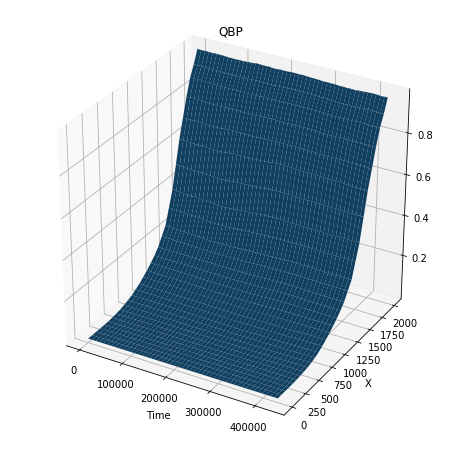

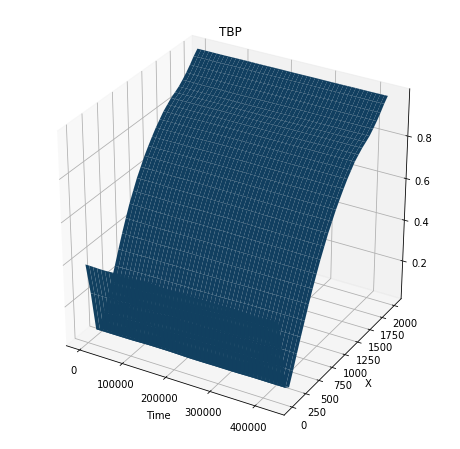

In [1026]:
data_model.visualize(0)

In [1105]:
torch.autograd.set_detect_anomaly(True)